Importing modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mode
import chiCa
from spks import *
from spks.sync import load_ni_sync_data,interp1d

%matplotlib widget

Loading nidaq and behavior data

In [2]:
sessionpath = Path('/home/data/GRB006/20240429_174359/')
sync_port = 0 # this is where the SMA of the probe is connected

(nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = load_ni_sync_data(sessionpath=sessionpath)
aponsets = apsyncdata[0]['file0_sync_onsets'][6] # this should be the same for you, its where the sync is on the probe

corrected_onsets = {} # This is a dictionary with the digital events that were connected to the breakout box.
for k in nionsets.keys():
    corrected_onsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')
del k

# if you need analog channels those are in "nisync"
nitime = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))

# everything is in samples, use this sampling rate
srate = apsyncdata[0]['sampling_rate']  

frame_rate = mode(1/(np.diff(corrected_onsets[1])/srate)) #corrected_onsets[1] are the frame samples, [2] are the trial start samples

analog_signal = nisync[:, 0] # analog stim signal

behavior_data = chiCa.load_trialdata('/home/data/GRB006/20240429_174359/chipmunk/GRB006_20240429_174359_chipmunk_DemonstratorAudiTask.mat')

/opt/conda/envs/spks-gabriel/lib/python3.12/site-packages/chiCa/chipmunk_analysis_tools.py:321: UserWarning: Found multisensory trials, assumed synchronous condition
  warnings.warn('Found multisensory trials, assumed synchronous condition')


Grab stim event times

In [3]:
t = nitime/srate #nidaq clock time vector in seconds
amp_threshold = 15000 #signal amplitude threshold
time_threshold = 0.04 #in seconds - minimum time between stim events
ii = np.where(np.diff(analog_signal>amp_threshold)==1)[0]
stim_ts = t[ii[np.diff(np.hstack([0,ii]))>time_threshold*srate]]
del amp_threshold, time_threshold, ii

first_stim_ts = [] #first in each trial
for ti in range(len(corrected_onsets[2]) - 1):
    start_time = corrected_onsets[2][ti] / srate
    end_time = corrected_onsets[2][ti + 1] / srate
    events_in_interval = stim_ts[(stim_ts > start_time) & (stim_ts < end_time)]
    
    if len(events_in_interval) > 0:
        first_stim_ts.append(events_in_interval[0])
    else:
        first_stim_ts.append(np.nan)
first_stim_ts = np.array(first_stim_ts)

del ti, start_time, end_time, events_in_interval

Loading and filtering KS results

In [4]:
kilosort_path = Path('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/')
sc = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_clusters.npy') #KS clusters
ss = np.load('/home/data/GRB006/20240429_174359/kilosort2.5/imec0/spike_times.npy') #KS spikes (in samples)
st = ss/srate #conversion from spike samples to spike times

clu = Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

# filter units for using Melin et al. 2024 criteria
mask = ((np.abs(clu.cluster_info.trough_amplitude - clu.cluster_info.peak_amplitude) > 50)
            & (clu.cluster_info.amplitude_cutoff < 0.1) 
            & (clu.cluster_info.isi_contamination < 0.1)
            & (clu.cluster_info.presence_ratio >= 0.6)
            & (clu.cluster_info.spike_duration > 0.1))

good_unit_ids = np.isin(sc,clu.cluster_info[mask].cluster_id.values)
del mask

Static PSTH plotting

Discarding 10 NaNs from input array


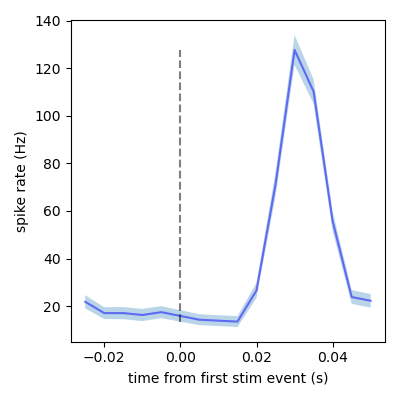

In [5]:
from utils import get_cluster_spike_times, compute_mean_sem
from viz import plot_psth
from spks.event_aligned import compute_firing_rate

binwidth_ms = 5
tpre = 0.025
tpost = 0.055

# population_timestamps = st[good_unit_ids]
single_unit_timestamps = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_unit_ids = good_unit_ids)
first_stim_psth, first_stim_ei = compute_firing_rate(first_stim_ts, single_unit_timestamps[154], tpre, tpost, binwidth_ms, kernel=None)

plt.figure(figsize=(4, 4))
plot_psth(compute_mean_sem(first_stim_psth), tpre, tpost, binwidth_ms, 'time from first stim event (s)', 'spike rate (Hz)')

Single neuron interactive viewer

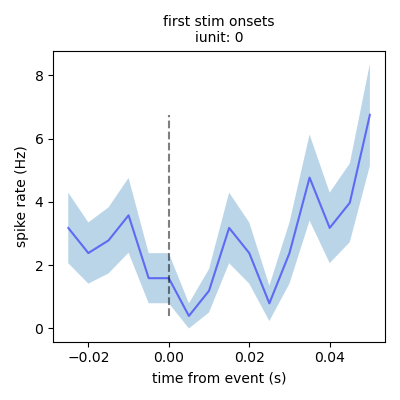

In [7]:
from viz import individual_psth_viewer

binwidth_ms = 5
tpre = 0.025
tpost = 0.055

plt.figure(figsize=(4, 4))
individual_psth_viewer(first_stim_ts, single_unit_timestamps, tpre, tpost, binwidth_ms, 'first stim onsets')